# Priors on Functions
Mark van der Wilk, Spring 2021, Probabilistic Inference, Imperial College London

This doc accompanies the lecture. It roughly follows the same plot, but
different bits are emphasised, so absorb them both.

## Introduction
Gaussian processes are an important tool for solving regression problems. In
many ways, they are the "gold standard" for performing regression. They are
mathematically well understood, and illustrate the behaviour of Bayesian models
very well. Practically, they often perform very well in tasks that
- are low dimensional (e.g. tens of dimensions rather than 100s),
- have little data (or data is expensive to obtain),
- are noisy (random fluctuations that obscure the signal),
- require uncertainty estimates.

In statistics, they are commonly applied in many areas, e.g. modelling
- the efficiency of chemical processes,
- disease spread in epidemiology (e.g. spatiotemporal models and point processes),
- the location of mineral deposits for mining (GPs are also known as Kriging),
- gene expression in cells.

In machine learning they are often used in lower dimensional noisy tasks, for
example in modelling the motion of dynamical systems.

They are strongly connected to neural networks through limits where the width
of layers is taken to infinity. This allows them to also be used to analyse
certain theoretical properties of neural networks.

Gaussian processes are nothing other than a different representation of
Bayesian Linear Regression (I like to say that they are a different
representation of a neural network layer). This different representation
improves on Bayesian Linear Regression by
- making it easier to specify sensible prior distributions (remember, our
  inferences are only as sensible as our prior assumptions!),
- providing better uncertainty estimates by allowing an infinite number of
  basis functions.

We will start by investigating some problems relating to Bayesian Linear
Regression, and then we will derive the solution, which turns out to be a
Gaussian process!

NOTE: When I talk about linear regression, I'm not talking about only fitting
linear functions. It's called "linear regression", since the model is linear
*in the parameters*. With basis functions, we can use linear regression to fit
non-linear functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow
from tools import datasets
from tools import plotting
from tools.lmflow import PolynomialBasisKernel, SqExpBasisFunctionKernel, LMR
from tools.misc import sample_prior

save_figures_location = "/Users/markvdw/Documents/teaching/probabilistic-inference/2021/slides/figures/gp/"
savefig = lambda fig, fn: fig.savefig(f"{save_figures_location}{fn}") if savefig is not None else None
pX = np.linspace(-5, 5, 500)[:, None]

# raw_d = datasets.load_data("01-airline.mat")
# ss = raw_d.subset(np.s_[:10])
# d = raw_d.normalise(ss.X.mean(), (ss.X.max() - ss.X.min()) / 4, ss.Y.mean(), ss.Y.std())
# d = d.subset(np.s_[:10])

raw_d = datasets.load_data("05-temperature.mat")
slice = np.r_[50:60, 145:250]
ss = raw_d.subset(slice)
nd = raw_d.normalise(ss.X.mean(), (ss.X.max() - ss.X.min()) / 4, ss.Y.mean(), ss.Y.std())


interp_d = []
# Vary between 110 and 120
for start in [50, 0]:
    slice = np.r_[start:55, 145:250]
    ld = nd.subset(slice)
    interp_d.append(ld)
d = interp_d[0]
gap_d = nd.subset(np.s_[55:145])

## Regression
We're interested in solving a regression task. We get input-output pairs
$\{\mathbf x_n, y_n\}_{n=1}^N$, and we want to find some function
$f: \mathcal X \to \mathcal Y$ to predict outputs for new unseen inputs. We
usually assume $\mathbf x_n \in \mathbb R^D, y_n \in \mathbb R$, but most
techniques can be generalised to all sorts of inputs, like sequences or graphs.

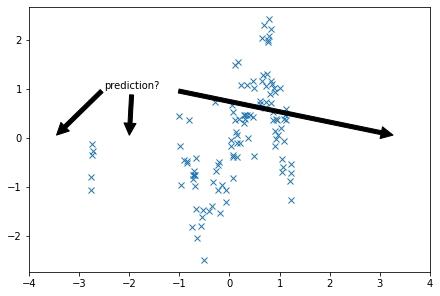

In [2]:
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(111)
ax.plot(d.X, d.Y, 'x')
ax.annotate('prediction?', xy=(-2.0, 0.0), xytext=(-2.5, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('', xy=(-3.5, 0.0), xytext=(-2.5, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('', xy=(3.5, 0.0), xytext=(-1.25, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.set_xlim(-4, 4)
savefig(fig, f"regression_problem.pdf")

## Maximum Likelihood Polynomial Regression
- Parameterise functions as sums of polynomials $f(x) = \sum_{d=0}^D x^d \theta_d$.
- Maximum likelihood.
- We fit with different degrees of polynomials.

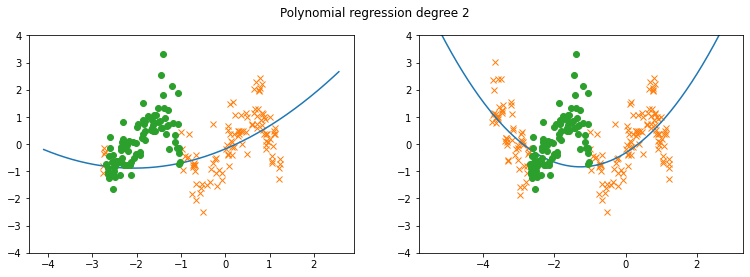

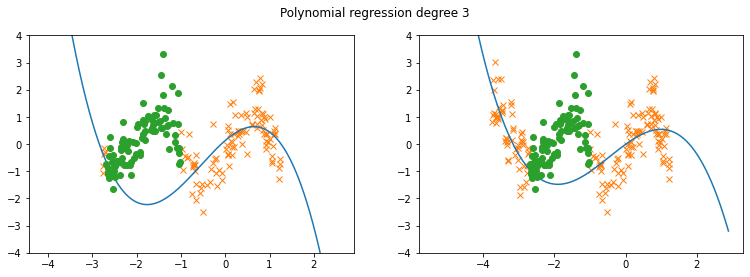

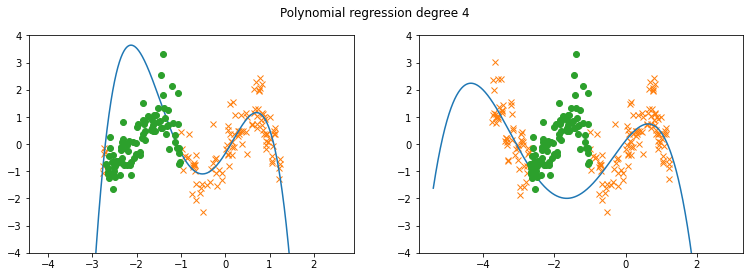

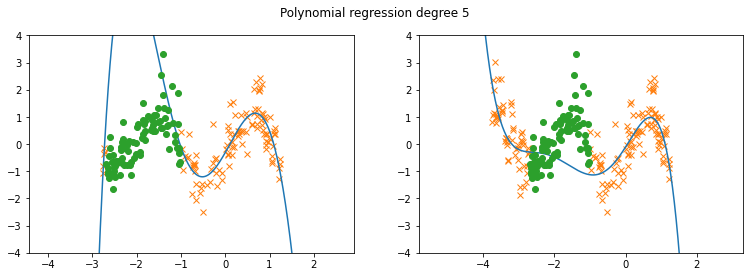

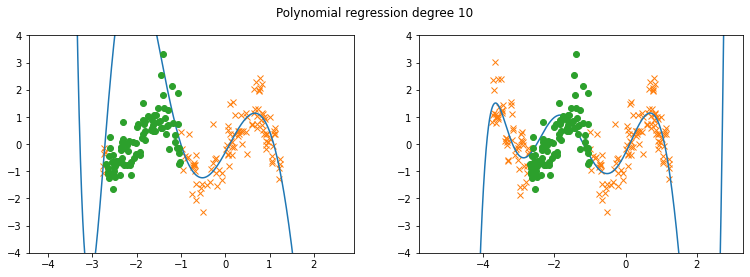

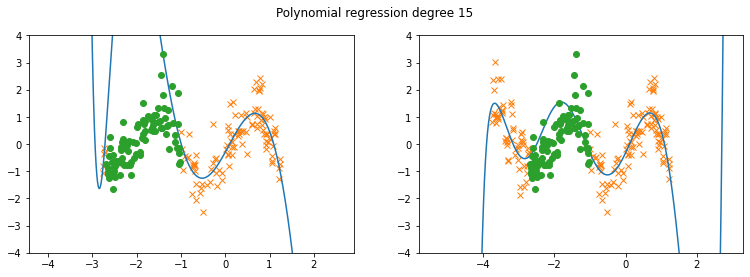

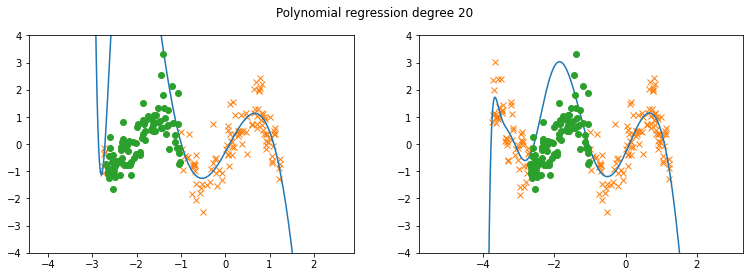

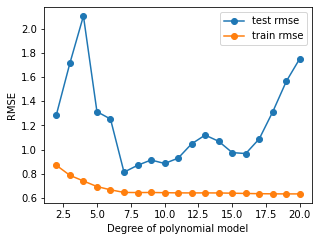

In [3]:
# Note that I actually use Bayes to get the "maximum likelihood" result here.
# Since the degree of the polynomial is smaller than the number of data, and
# that I set the noise variance to something very small, this works out.
degrees = range(2, 21)
plot_degrees = [2, 3, 4, 5, 10, 15, 20]
test_rmses = []
train_rmses = []
for degree in degrees:
    if degree in plot_degrees:
        fig, axs = plt.subplots(1, 2, figsize=(12.8, 4))
        fig.suptitle(f"Polynomial regression degree {degree}")
    for i, (ax, ld) in enumerate(zip(axs, interp_d)):
        m = LMR((ld.X, ld.Y), PolynomialBasisKernel(degree))
        m.kernel.lengthscales = 2.8
        m.likelihood.variance.assign(1e-4)
        if degree in plot_degrees:
            plotting.plot_1d_model(m, plot_samples=False, plot_mean=True, plot_var=False, ax=ax)
            ax.plot(gap_d.X, gap_d.Y, 'o', color='C2')
            ax.set_ylim(-4, 4)

        if i == 1:
            test_rmses.append(np.mean((m.predict_y(gap_d.X)[0].numpy() - gap_d.Y) ** 2.0) ** 0.5)
            train_rmses.append(np.mean((m.predict_y(ld.X)[0].numpy() - ld.Y) ** 2.0) ** 0.5)

    if degree in plot_degrees:
        savefig(fig, f"regression_poly{degree}.pdf")

fig, ax = plt.subplots(1, 1, figsize=(4.8, 3.6))
ax.plot(degrees, test_rmses, '-o', label="test rmse")
ax.plot(degrees, train_rmses, '-o', label="train rmse")
ax.set_xlabel("Degree of polynomial model")
ax.set_ylabel("RMSE")
ax.legend()
savefig(fig, f"regression_overfitting.pdf")

What degree of polynomial should I use? There is no real good answer:
- Regardless of the degree, the extrapolation to the left is always too extreme and wrong.
- Lower degree polynomials have less extreme interpolations, but less
  flexibility to fit additional data.
- Higher degree polynomials interpolate in much more extreme ways, but can fit the additional data...

Extreme predictions when fitting with maximum likelihood often comes from
overfitting. Will things behave behave better if we do Bayesian inference?

## Bayesian Polynomial Regression
So let's now find the posterior over the parameters. Will we get less extreme
extrapolations if we add uncertainty? Or perhaps the uncertainty will at least
give an indication that the predictions are unreliable?

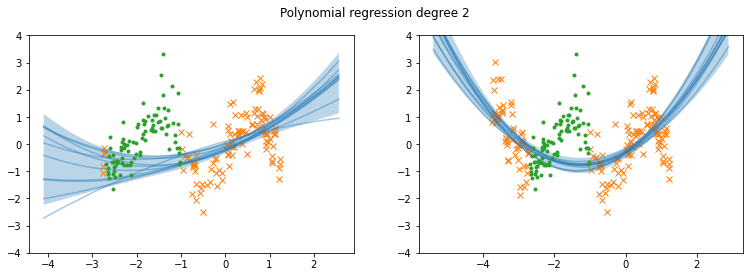

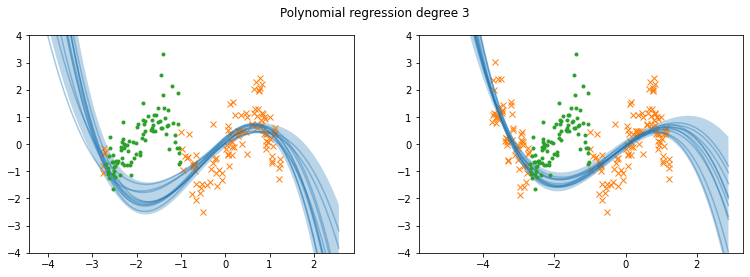

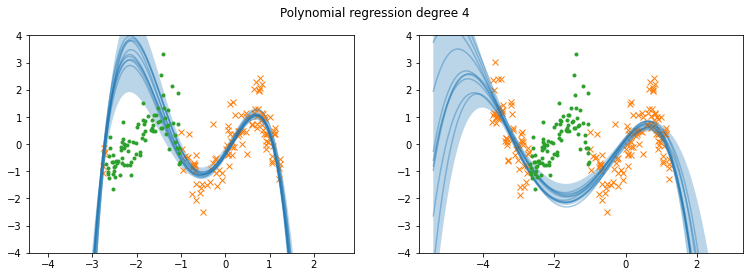

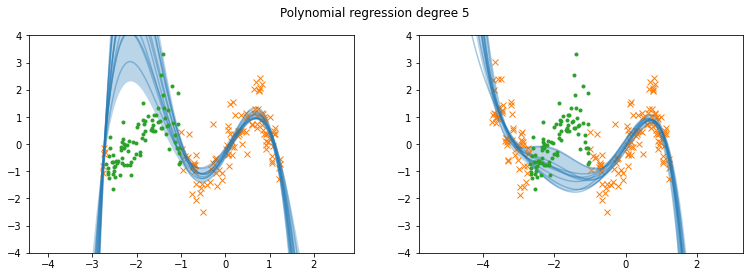

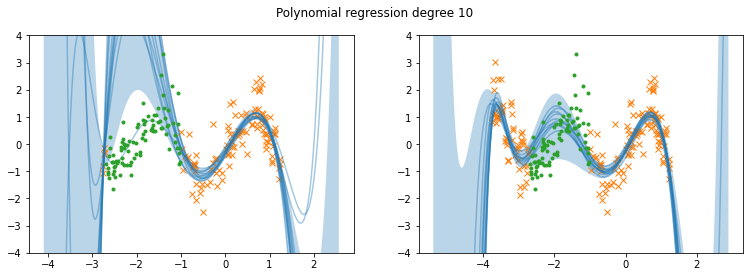

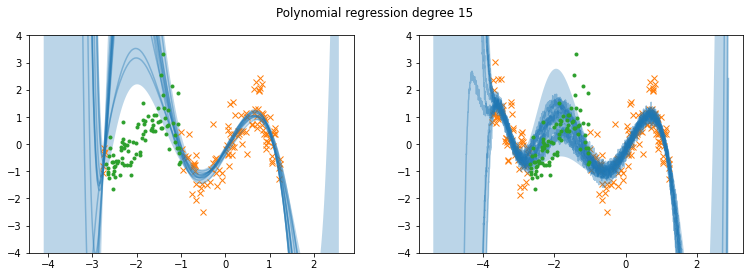

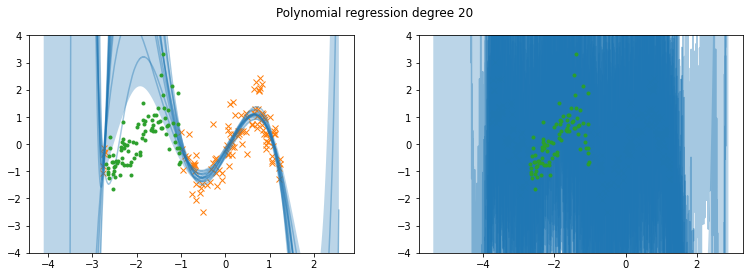

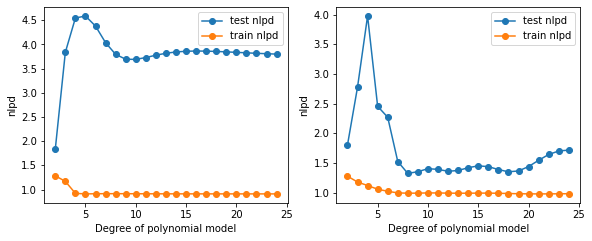

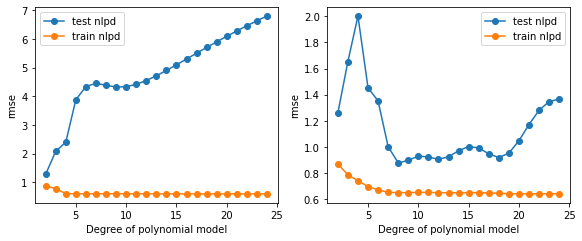

In [4]:
# Note that I actually use Bayes to get the "maximum likelihood" result here.
# Since the degree of the polynomial is smaller than the number of data, and
# that I set the noise variance to something very small, this works out.
degrees = range(2, 25)
plot_degrees = [2, 3, 4, 5, 10, 15, 20]
test_nlpds_low, train_nlpds_low = [], []
test_nlpds_high, train_nlpds_high = [], []
test_rmses_low, train_rmses_low = [], []
test_rmses_high, train_rmses_high = [], []
for degree in degrees:
    if degree in plot_degrees:
        fig, axs = plt.subplots(1, 2, figsize=(12.8, 4))
        fig.suptitle(f"Polynomial regression degree {degree}")
    for i, (ax, ld) in enumerate(zip(axs, interp_d)):
        m = LMR((ld.X, ld.Y), PolynomialBasisKernel(degree))
        m.kernel.lengthscales = 2.8
        m.likelihood.variance.assign(1e-4)

        # I'm fitting the hyperparameters by maximising the marginal likelihood.
        # We will discuss this in detail later in the course, but for now all
        # you need to believe is that this is a good way to set the parameters
        # of polynomial regression. I'm being charitable twoards polynomial
        # regression here.
        opt = gpflow.optimizers.Scipy()
        opt.minimize(m.training_loss, variables=m.trainable_variables)

        lpds = -np.mean(m.predict_log_density((gap_d.X, gap_d.Y)).numpy())
        (test_nlpds_low if i == 0 else test_nlpds_high).append(lpds)
        rmses = np.mean((m.predict_y(gap_d.X)[0].numpy() - gap_d.Y) ** 2.0) ** 0.5
        (test_rmses_low if i == 0 else test_rmses_high).append(rmses)
        lpds = -np.mean(m.predict_log_density((ld.X, ld.Y)).numpy())
        (train_nlpds_low if i == 0 else train_nlpds_high).append(lpds)
        rmses = np.mean((m.predict_y(ld.X)[0].numpy() - ld.Y) ** 2.0) ** 0.5
        (train_rmses_low if i == 0 else train_rmses_high).append(rmses)

        if degree in plot_degrees:
            plotting.plot_1d_model(m, plot_samples=True, plot_mean=False, plot_var="f", ax=ax)
            ax.plot(gap_d.X, gap_d.Y, '.', color='C2')
            ax.set_ylim(-4, 4)

    if degree in plot_degrees:
        savefig(fig, f"regression_poly{degree}_bayes.pdf")

for metric_name, metric in zip(
        ["nlpd", "rmse"],
        [
            [(train_nlpds_low, test_nlpds_low), (train_nlpds_high, test_nlpds_high)],
            [(train_rmses_low, test_rmses_low), (train_rmses_high, test_rmses_high)]
        ]):
    fig, axs = plt.subplots(1, 2, figsize=(9.6, 3.6))
    for ax, (train_metric, test_metric) in zip(axs, metric):
        ax.plot(degrees, test_metric, '-o',label="test nlpd")
        ax.plot(degrees, train_metric, '-o', label="train nlpd")
        # ax.plot(degrees, test_rmses, '-o', label="test rmse")
        # ax.plot(degrees, train_rmses, '-o', label="train rmse")
        ax.set_xlabel("Degree of polynomial model")
        ax.set_ylabel(metric_name)
        ax.legend()
    savefig(fig, f"regression_overfitting_{metric_name}_bayes.pdf")

- We observe that at least for the high degree models, we see large uncertainty
  in the extrapolation. This is good.
- Still, wildly huge uncertainty the moment you start extrapolating isn't
  particularly useful, and certainly not realistic.
- Additionally, the same trade-offs exist for between models with different
  degrees of polynomials as earlier.

## Investigating the Prior
So why does our model make such extreme predictions? Why does it seem so
sensitive in strange ways to additional data?

Remember: Our inferences depend on our assumptions. Incorrect assumptions lead
to incorrect conclusions, even if our reasoning was correct!

Since our assumptions are encoded in the prior, let's investigate the prior. We
can do this by *drawing samples* from our prior, to see what characteristics it
has, and whether it roughly matches that of the data.

By placing a prior on the parameters, we place a prior on functions, because
there is a 1-1 relationship between parameters and functions. So let's look at
the functions we get, to see if we have the right properties.


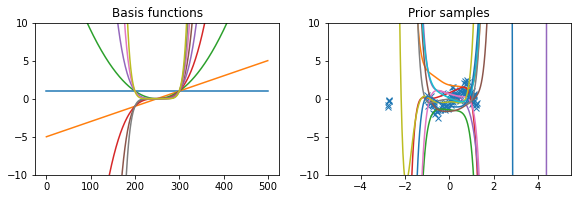

In [5]:
k = PolynomialBasisKernel(8)
samples = sample_prior(k, pX)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9.6, 2.8))
ax1.plot(k.Phi(pX))
ax1.set_ylim(-10, 10)
ax1.set_title("Basis functions")
ax2.plot(d.X, d.Y, 'x')
ax2.plot(pX, samples)
ax2.set_ylim(-10, 10)
ax2.set_title("Prior samples")
savefig(fig, f"regression_poly_prior.pdf")

The reason it extrapolates so wildly, is that our prior expresses the belief
that there are wild variations in the functions. This doesn't seem like a good
assumption to make.

So what do we do instead?

## Priors and Posteriors
Posterior is the prior, but constrained by the likelihood. The likelihood cuts
out everything allowed by the prior and leaves only density in regions that are
allowed by both the prior and likelihood (figure 7.11 in Murphy).
- A posterior will never place probability on a set that has no probability
  under the prior. This can limit your learning.
- It is also bad to put too much probability on sets that will never occur! It
  will take lots of data for the likelihood to rule out these possibilities.

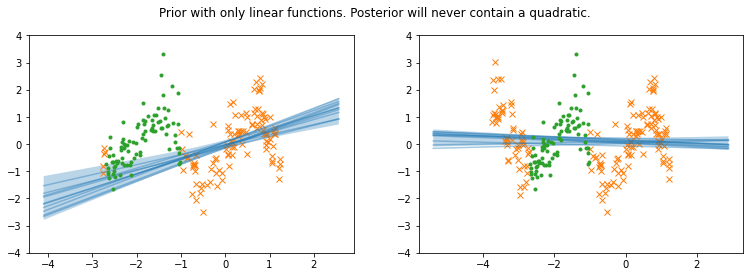

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 4))
fig.suptitle(f"Prior with only linear functions. Posterior will never contain a quadratic.")
for ax, ld in zip(axs, interp_d):
    m = LMR((ld.X, ld.Y), PolynomialBasisKernel(1))
    m.kernel.lengthscales = 2.8
    m.likelihood.variance.assign(1e-4)

    opt = gpflow.optimizers.Scipy()
    opt.minimize(m.training_loss, variables=m.trainable_variables)

    plotting.plot_1d_model(m, plot_samples=True, plot_mean=False, plot_var="f", ax=ax)
    ax.plot(gap_d.X, gap_d.Y, '.', color='C2')
    ax.set_ylim(-4, 4)

## Gaussian Basis Functions
To fix the behaviour of our model, we change the prior to something more
sensible.
- We prevent wild extrapolations by choosing basis functions which are
  *bounded* in output value.
- We prevent sensitivity on distant values by choosing basis functions with a
  bounded input range where they have effect. (This isn't *necessary* to get this
  behaviour, but it does work.)

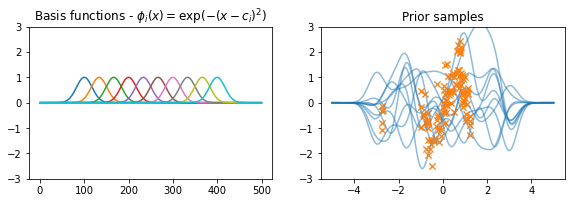

In [7]:
k = SqExpBasisFunctionKernel(10, (-3, 3), lengthscales=0.5)
samples = sample_prior(k, pX)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9.6, 2.8))
ax1.plot(k.Phi(pX))
ax1.set_ylim(-3, 3)
ax1.set_title("Basis functions - $\phi_i(x) = \exp(-(x-c_i)^2)$")
ax2.plot(d.X, d.Y, 'x', color='C1')
ax2.plot(pX, samples, color='C0', alpha=0.5)
ax2.plot(d.X, d.Y, 'x', color='C1')
ax2.set_ylim(-3, 3)
ax2.set_title("Prior samples")
savefig(fig, f"regression_sqexp_prior.pdf")

In [8]:
m = LMR((d.X, d.Y), SqExpBasisFunctionKernel(10, (-3, 2)))
opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables)
print(m.log_marginal_likelihood().numpy())
gpflow.utilities.print_summary(m)

-113.4990489866683
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ LMR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.10647  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ LMR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.506573 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ LMR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.375127 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═

No handles with labels found to put in legend.


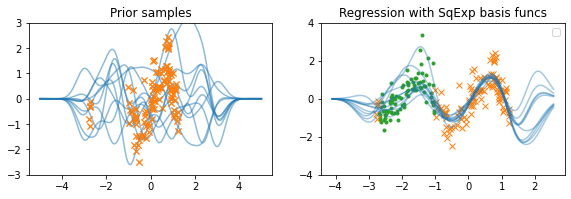

In [9]:
fig, (ax2, ax) = plt.subplots(1, 2, figsize=(9.6, 2.8))
plt.plot(gap_d.X, gap_d.Y, '.', color='C2')
plotting.plot_1d_model(m, plot_samples=True, plot_mean=False, plot_var=False, ax=ax)
ax.set_ylim(-4, 4)
ax.legend()
ax.set_title("Regression with SqExp basis funcs")

ax2.plot(d.X, d.Y, 'x', color='C1')
ax2.plot(pX, samples, color='C0', alpha=0.5)
ax2.plot(d.X, d.Y, 'x', color='C1')
ax2.set_ylim(-3, 3)
ax2.set_title("Prior samples")
savefig(fig, f"regression_sqexp{m.kernel.centres.shape[0]}.pdf")

This looks a lot better! The interpolation looks great. But what about the
extrapolation? Is it sensible that there is no uncertainty there?

No! The prior is *super certain* that no function deviation will occur there.
This doesn't seem like a very realistic assumption.

If we don't put a basis function somewhere, we cannot represent uncertainty
there! Can we not just put basis functions everywhere?

We need an infinite number of basis functions!